# Clasificador de sentimiento de texto usando transformadores

**Nombre:** Fernando Márquez Pérez

**No. de Cuenta:**  420004482

In [126]:
from tqdm.auto import trange
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.functional as F

from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocesamiento

Descargamos y cargamos el [dataset](https://www.kaggle.com/datasets/arnavsharmaas/chatbot-dataset-topical-chat)


In [4]:
df = pd.read_csv("topical_chat.csv")
df

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",Surprised
188374,8628,"I havent seen that episode, I might google it...",Curious to dive deeper
188375,8628,I don't think I have either. That's an insane...,Curious to dive deeper
188376,8628,"I did, my little brother used to love Thomas ...",Happy


In [88]:
labels = df.sentiment.unique()
labels_dic = {k:v for v,k in enumerate(labels)}

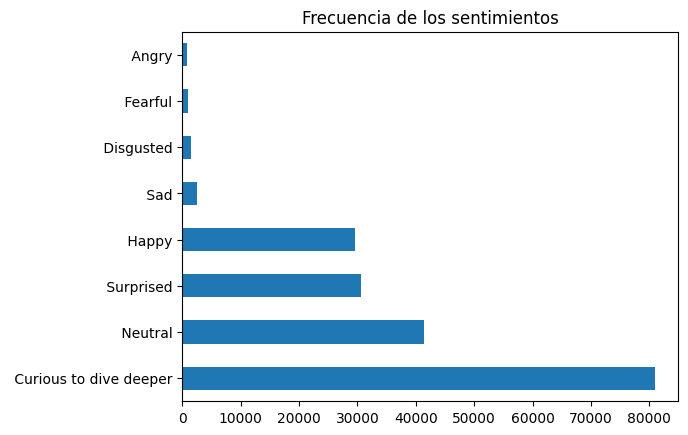

In [5]:
df.sentiment.value_counts().plot(kind="barh",
                                 title="Frecuencia de los sentimientos")
plt.show()

Lo que podemos ver del conjunto es que las clases no están corresctamente balanceadas: *curious to dive deeper* es la clase predominante porque es donde caen todos los mensajes relacionados a preguntas. Es probable que las 4 clases con menos elementos no den buenos resultados.

Para poder trabajar con el transformador necesitamos codificar el texto a tensores y las etiquetas a valores numéricos, para lo que nos apoyaremos de `torchtext`. Crearemos un Dataset para los mensajes con su texto y etiqueta codificados.

In [254]:
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, df.message))

In [7]:
vocab(tokenizer(df.message[0]))

[26, 9, 5, 159, 11, 246, 66, 3759, 10]

In [154]:
class MessageDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.data = df
    d = [torch.tensor(vocab(tokenizer(message))).to(device) for message in df.message]
    self.X =  

    self.y = torch.tensor([labels_dic[sentiment] for sentiment in df.sentiment])

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [155]:
df_train, df_test = train_test_split(df, test_size=0.2)
train_set = MessageDataset(df_train)
test_set = MessageDataset(df_test)

In [117]:
print("Ejemplo de codificación:")
print(train_set[0])
tmp = train_set.data.iloc[0]
print(tmp.message, tmp.sentiment, sep=", ")

Ejemplo de codificación:
(tensor([401,   3,  20,   9, 116, 560, 730, 550,  22, 205,  10]), 0)
 Yep, do you use online social media like Facebook?,  Curious to dive deeper


Con los datasets preparados, procedemos a crear el modelo.

### Creación del modelo

Optamos por un modelo basado en **transformadores** por probar algo que no habíamos programado durando las clases. Las otras dos posibles propuestas fueron: Alguna variante de RNN y una CNN.

El modelo del transformador se basa en varios componentes:
- Una capa de embedding
- Una capa para la codificación de posición
- Un codificador
- Capas completamente conectadas

En nuestro modelo no utilizamos un decodificador porque no nos preocupamos por generar texto de regreso, sino por obtener la etiqueta del sentimiento.

Copiamos parte de la estructura del transformación de la que se muestra en el artículo *Atention Is All You Need*, que es la referencia que utiliza el [tutorial de pytorch para NLP](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

In [122]:
# Este código es el tutorial mencionado antes y aplica sen y cos para generar
# una matriz con la información posicional, como lo visto en clase
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [165]:
class SentimentTransformer(nn.Module):
  def __init__(
      self,
      num_tokens,
      model_dim,
      num_heads,
      dim_ff,
      num_layers,
      dropout
  ):
    super().__init__()
    # Modelo de embedding
    self.embedding = nn.Embedding(num_tokens, model_dim)
    # codificador posicional
    self.pos_encoder = PositionalEncoding(model_dim, dropout, num_tokens)
    # codificador
    encoder_layers = nn.TransformerEncoderLayer(model_dim, num_heads, dim_ff, dropout)
    self.encoder = nn.TransformerEncoder(encoder_layers, num_layers)
    # Capa lineal
    self.linear = nn.Linear(model_dim, len(labels))
    self.model_dim = model_dim

  def forward(self, X):
    # Preparamos la matriz
    # Lo multiplicados para darle más peso al embedding al sumar con pos_encoder
    tmp = self.embedding(X) * math.sqrt(self.model_dim)
    tmp = self.pos_encoder(tmp)
    # Entramos al transformador
    res = self.encoder(tmp)
    res = self.linear(res)
    # Devolvemos los logits
    return res


### Entrenamiento

Para entrenar iteramos sobre los datos de entrenamieto y calculamos la pérdida paso a paso, se intentó realizar un entrenamiento por lotes pero los tamaños distintos de las cadenas fueron un problema y, sabiendo que el embedding se encargaba de eso, preferimos no cambiar el dataset.

In [285]:
def train(model, train_data, test_data, epochs, criterion, optimizer):
  model.train()
  error = []
  for epoch in trange(1, epochs+1):
    for text, label in train_data:
      # Calcula el error
      logits = model(text.unsqueeze(0))
      probs = torch.softmax(logits, dim=1)
      loss = criterion(probs.mean(1), torch.tensor([label]))
      error.append(loss.item())
      
      # Actualiza
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
          count = 0
          for x, y_true in test_data:
            y_pred = torch.sigmoid(model(x), dim=1).argmax(dim=1, keepdim=True)
            if y_pred == y_true: count += 1

        print(f"Epoch {epoch}, loss = {loss}, acc = {count / len(test_data)}")
        model.train()

    plt.plot(error)
    plt.show()

In [286]:
model = SentimentTransformer(len(vocab), 200, 2, 200, 2, 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train(model, train_set, test_set, 100, criterion, optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored